In [661]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

In [662]:
train_df = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test_df = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [663]:
'''
train_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())
train_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())
train_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())
train_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())
def processError(df):
    if df == '1900/3/10 0:00':
        return 70
    return df
train_df['A25'] = train_df['A25'].apply(lambda x: processError(x))
train_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())
train_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())
train_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())
train_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())
train_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())
'''

"\ntrain_df['A21'] = train_df['A21'].fillna(train_df['A21'].median())\ntrain_df['B1'] = train_df['B1'].fillna(train_df['B1'].median())\ntrain_df['B8'] = train_df['B8'].fillna(train_df['B8'].median())\ntrain_df['B12'] = train_df['B12'].fillna(train_df['B12'].median())\ndef processError(df):\n    if df == '1900/3/10 0:00':\n        return 70\n    return df\ntrain_df['A25'] = train_df['A25'].apply(lambda x: processError(x))\ntrain_df['A25'] = train_df['A25'].fillna(train_df['A25'].median())\ntrain_df['A23'] = train_df['A23'].fillna(train_df['A23'].median())\ntrain_df['B2'] = train_df['B2'].fillna(train_df['B2'].median())\ntrain_df['B3'] = train_df['B3'].fillna(train_df['B3'].median())\ntrain_df['B13'] = train_df['B13'].fillna(train_df['B13'].median())\n"

In [664]:
'''
test_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())
test_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())
test_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())
'''

"\ntest_df['A25'] = test_df['A25'].fillna(train_df['A25'].median())\ntest_df['A27'] = test_df['A27'].fillna(train_df['A27'].median())\ntest_df['B1'] = test_df['B1'].fillna(train_df['B1'].median())\n"

In [665]:
views = []
for col in train_df.columns:
    views.append((col, train_df[col].nunique(), train_df[col].isnull().sum() * 100 / train_df.shape[0], train_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, train_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,174,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,87,0,19.054441,object
27,A27,13,0,45.128940,int64


In [666]:
views = []
for col in test_df.columns:
    views.append((col, test_df[col].nunique(), test_df[col].isnull().sum() * 100 / test_df.shape[0], test_df[col].value_counts(normalize=True, dropna=False).values[0] * 100, test_df[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,int64


In [667]:
for df in [train_df, test_df]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

features = list(train_df.columns)
for col in train_df.columns:
    rate = train_df[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        features.remove(col)
train_df = train_df[features]
features.remove('score')
test_df = test_df[features]

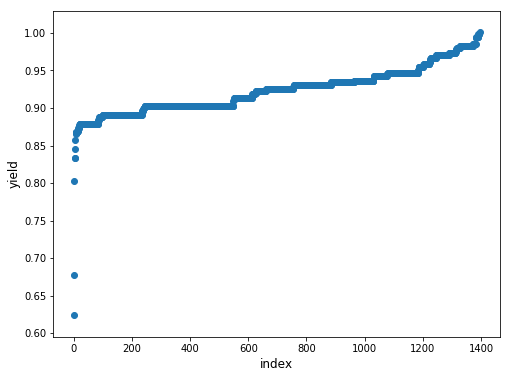

In [668]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

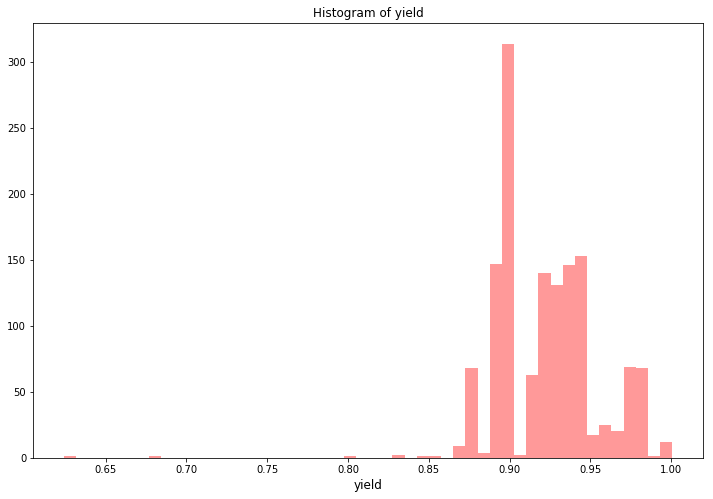

In [669]:
plt.figure(figsize=(12,8))
sns.distplot(train_df[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [670]:
train_df = train_df[train_df[target_col]>0.87]

In [671]:
def TimeToInt(t, previous = 0):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
        if tm < previous:
            tm += 24
    except:
        return (30*60)/3600
    
    return tm

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = (int(eh)*60+int(em)-int(sm)-int(sh)*60)/60
        if duration < 0:
            duration += 24
        return duration
    except:
        return 0

def Between(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    duration = 0
    try:
        duration = t1 - t2
        if duration < 0:
            duration += 24
    except:
        duration = 0
    return duration

def getBeforeTime(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1       
    try:
        tm = (int(sh)*3600+int(sm)*60)/3600
    except:
        if se=='19:-20:05':
            return (19*3600+5*60)/3600
        elif se=='15:00-1600':
            return 15*3600/3600       
    return tm

def adjust(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < t2:
        return t1 + 24
    return t1

def getAfterTime(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < 0 or  t2 < 0:
        return -1
    return t1 + t2

In [672]:
target = train_df['score']
del train_df['score']
data = pd.concat([train_df,test_df],axis=0,ignore_index=True)
data = data.fillna(-1)
del data['sample id']

In [673]:
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(TimeToInt)

In [674]:
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_duration'] = data.apply(lambda data: TimeToDuration(data[f]), axis=1)

for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_before_time'] = data.apply(lambda data: getBeforeTime(data[f]), axis=1)
    
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_after_time'] = data.apply(lambda data: getAfterTime(data[f+'_before_time'], data[f+'_duration']), axis=1)

In [675]:
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

for f in [['A20_before_time','A16'],['A28_before_time', 'A26'],['B4_before_time','A28_before_time'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)
    
for f in [['A20_after_time','A20_before_time'],['A28_after_time', 'A28_before_time'],['B4_after_time','B4_before_time'],['B9_after_time', 'B9_before_time'],['B10_after_time','B10_before_time'],['B11_after_time','B11_before_time']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

In [676]:
for f in [['A20_before_time','A5'],['A28_before_time', 'A5'],['B4_before_time','A5'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A20_after_time','A5'],['A28_after_time', 'A5'],['B4_after_time','A5'],['B9_after_time', 'A5'],['B10_after_time','A5'],['B11_after_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A5'],['A14', 'A5'],['A16', 'A5'],['A24', 'A5'],['A26', 'A5'],['B5', 'A5'],['B7', 'A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]+'duration'] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in ['A20','A28','B4','B9','B10','B11']:
    del data[f]

In [677]:
def merge_median(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].median()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_mean(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].mean()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_max(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].max()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_min(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].min()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_std(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].std()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

In [678]:
data = merge_median(data, ['A7'], 'A8', 'A9_A10_median')
data = merge_median(data, ['A9'], 'A10', 'A9_A10_median')
data = merge_median(data, ['A12'], 'A11', 'A12_A11_median')
data = merge_median(data, ['A15'], 'A14', 'A15_A14_median')
data = merge_median(data, ['A17'], 'A16', 'A17_A16_median')
data = merge_median(data, ['A25'], 'A24', 'A25_A24_median')
data = merge_median(data, ['A27'], 'A26', 'A27_A26_median')
data = merge_median(data, ['B6'], 'B5', 'B6_B5_median')
data = merge_median(data, ['B8'], 'B7', 'B8_B7_median')

data = merge_mean(data, ['A7'], 'A8', 'A9_A10_mean')
data = merge_mean(data, ['A9'], 'A10', 'A9_A10_mean')
data = merge_mean(data, ['A12'], 'A11', 'A12_A11_mean')
data = merge_mean(data, ['A15'], 'A14', 'A15_A14_mean')
data = merge_mean(data, ['A17'], 'A16', 'A17_A16_mean')
data = merge_mean(data, ['A25'], 'A24', 'A25_A24_mean')
data = merge_mean(data, ['A27'], 'A26', 'A27_A26_mean')
data = merge_mean(data, ['B6'], 'B5', 'B6_B5_mean')
data = merge_mean(data, ['B8'], 'B7', 'B8_B7_mean')

data = merge_max(data, ['A7'], 'A8', 'A9_A10_max')
data = merge_max(data, ['A9'], 'A10', 'A9_A10_max')
data = merge_max(data, ['A12'], 'A11', 'A12_A11_max')
data = merge_max(data, ['A15'], 'A14', 'A15_A14_max')
data = merge_max(data, ['A17'], 'A16', 'A17_A16_max')
data = merge_max(data, ['A25'], 'A24', 'A25_A24_max')
data = merge_max(data, ['A27'], 'A26', 'A27_A26_max')
data = merge_max(data, ['B6'], 'B5', 'B6_B5_max')
data = merge_max(data, ['B8'], 'B7', 'B8_B7_max')

data = merge_min(data, ['A7'], 'A8', 'A9_A10_min')
data = merge_min(data, ['A9'], 'A10', 'A9_A10_min')
data = merge_min(data, ['A12'], 'A11', 'A12_A11_min')
data = merge_min(data, ['A15'], 'A14', 'A15_A14_min')
data = merge_min(data, ['A17'], 'A16', 'A17_A16_min')
data = merge_min(data, ['A25'], 'A24', 'A25_A24_min')
data = merge_min(data, ['A27'], 'A26', 'A27_A26_min')
data = merge_min(data, ['B6'], 'B5', 'B6_B5_min')
data = merge_min(data, ['B8'], 'B7', 'B8_B7_min')

data = merge_std(data, ['A7'], 'A8', 'A9_A10_std')
data = merge_std(data, ['A9'], 'A10', 'A9_A10_std')
data = merge_std(data, ['A12'], 'A11', 'A12_A11_std')
data = merge_std(data, ['A15'], 'A14', 'A15_A14_std')
data = merge_std(data, ['A17'], 'A16', 'A17_A16_std')
data = merge_std(data, ['A25'], 'A24', 'A25_A24_std')
data = merge_std(data, ['A27'], 'A26', 'A27_A26_std')
data = merge_std(data, ['B6'], 'B5', 'B6_B5_std')
data = merge_std(data, ['B8'], 'B7', 'B8_B7_std')

In [679]:
categorical_columns = [f for f in data.columns]
for f in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        data[f+'_median'] = data[f].median()
        data[f+'_std'] = data[f].std()
        data[f+'_max'] = data[f].max()
        data[f+'_min'] = data[f].min()
        data[f+'_**2'] = data[f].min()**2
        data[f+'_**1/2'] = data[f].min()**(1/2)
    
print(data.shape)

(1531, 679)


In [680]:
data.head()

,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration,A9_A10_median_x,A9_A10_median_y,A12_A11_median,A15_A14_median,A17_A16_median,A25_A24_median,A27_A26_median,B6_B5_median,B8_B7_median,A9_A10_mean_x,A9_A10_mean_y,A12_A11_mean,A15_A14_mean,A17_A16_mean,A25_A24_mean,A27_A26_mean,B6_B5_mean,B8_B7_mean,A9_A10_max_x,A9_A10_max_y,A12_A11_max,A15_A14_max,A17_A16_max,A25_A24_max,A27_A26_max,B6_B5_max,B8_B7_max,A9_A10_min_x,A9_A10_min_y,A12_A11_min,A15_A14_min,A17_A16_min,A25_A24_min,A27_A26_min,B6_B5_min,B8_B7_min,A9_A10_std_x,A9_A10_std_y,A12_A11_std,A15_A14_std,A17_A16_std,A25_A24_std,A27_A26_std,B6_B5_std,B8_B7_std,A5_median,A5_std,A5_max,A5_min,A5_**2,A5_**1/2,A6_median,A6_std,A6_max,A6_min,A6_**2,A6_**1/2,A7_median,A7_std,A7_max,A7_min,A7_**2,A7_**1/2,A8_median,A8_std,A8_max,A8_min,A8_**2,A8_**1/2,A9_median,A9_std,A9_max,A9_min,A9_**2,A9_**1/2,A10_median,A10_std,A10_max,A10_min,A10_**2,A10_**1/2,A11_median,A11_std,A11_max,A11_min,A11_**2,A11_**1/2,A12_median,A12_std,A12_max,A12_min,A12_**2,A12_**1/2,A14_median,A14_std,A14_max,A14_min,A14_**2,A14_**1/2,A15_median,A15_std,A15_max,A15_min,A15_**2,A15_**1/2,A16_median,A16_std,A16_max,A16_min,A16_**2,A16_**1/2,A17_median,A17_std,A17_max,A17_min,A17_**2,A17_**1/2,A19_median,A19_std,A19_max,A19_min,A19_**2,A19_**1/2,A22_median,A22_std,A22_max,A22_min,A22_**2,A22_**1/2,A24_median,A24_std,A24_max,A24_min,A24_**2,A24_**1/2,A25_median,A25_std,A25_max,A25_min,A25_**2,A25_**1/2,A26_median,A26_std,A26_max,A26_min,A26_**2,A26_**1/2,A27_median,A27_std,A27_max,A27_min,A27_**2,A27_**1/2,B1_median,B1_std,B1_max,B1_min,B1_**2,B1_**1/2,B5_median,B5_std,B5_max,B5_min,B5_**2,B5_**1/2,B6_median,B6_std,B6_max,B6_min,B6_**2,B6_**1/2,B7_median,B7_std,B7_max,B7_min,B7_**2,B7_**1/2,B8_median,B8_std,B8_max,B8_min,B8_**2,B8_**1/2,B12_median,B12_std,B12_max,B12_min,B12_**2,B12_**1/2,B14_median,B14_std,B14_max,B14_min,B14_**2,B14_**1/2,A20_duration_median,A20_duration_std,A20_duration_max,A20_duration_min,A20_duration_**2,A20_duration_**1/2,A28_duration_median,A28_duration_std,A28_duration_max,A28_duration_min,A28_duration_**2,A28_duration_**1/2,B4_duration_median,B4_duration_std,B4_duration_max,B4_duration_min,B4_duration_**2,B4_duration_**1/2,B9_duration_median,B9_duration_std,B9_duration_max,B9_duration_min,B9_duration_**2,B9_duration_**1/2,B10_duration_median,B10_duration_std,B10_duration_max,B10_duration_min,B10_duration_**2,B10_duration_**1/2,B11_duration_median,B11_duration_std,B11_duration_max,B11_duration_min,B11_duration_**2,B11_duration_**1/2,A20_before_time_median,A20_before_time_std,A20_before_time_max,A20_before_time_min,A20_before_time_**2,A20_before_time_**1/2,A28_before_time_median,A28_before_time_std,A28_before_time_max,A28_before_time_min,A28_before_time_**2,A28_before_time_**1/2,B4_before_time_median,B4_before_time_std,B4_before_time_max,B4_before_time_min,B4_before_time_**2,B4_before_time_**1/2,B9_before_time_median,B9_before_time_std,B9_before_time_max,B9_before_time_min,B9_before_time_**2,B9_before_time_**1/2,B10_before_time_median,B10_before_time_std,B10_before_time_max,B10_before_time_min,B10_before_time_**2,B10_before_time_**1/2,B11_before_time_median,B11_before_time_std,B11_before_time_max,B11_before_time_min,B11_before_time_**2,B11_before_time_**1/2,A20_after_time_median,A20_after_time_std,A20_after_time_max,A20_after_time_min,A20_after_time_**2,A20_after_time_**1/2,A28_after_time_median,A28_after_time_std,A28_after_time_max,A28_after_time_min,A28_after_time_**2,A28_after_time_**1/2,B4_after_time_median,B4_after_time_std,B4_after_time_max,B4_after_time_min,B4_after_time_**2,B4_after_time_**1

In [681]:
data.fillna(-1, inplace=True)
categorical_columns = [f for f in data.columns]
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1381, 679)
(150, 679)


In [682]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 904)
(150, 904)


In [683]:
X_train = train[mean_columns].values
X_test = test[mean_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 2025)
(150, 2025)


In [684]:
train.head()

,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration,A9_A10_median_x,A9_A10_median_y,A12_A11_median,A15_A14_median,A17_A16_median,A25_A24_median,A27_A26_median,B6_B5_median,B8_B7_median,A9_A10_mean_x,A9_A10_mean_y,A12_A11_mean,A15_A14_mean,A17_A16_mean,A25_A24_mean,A27_A26_mean,B6_B5_mean,B8_B7_mean,A9_A10_max_x,A9_A10_max_y,A12_A11_max,A15_A14_max,A17_A16_max,A25_A24_max,A27_A26_max,B6_B5_max,B8_B7_max,A9_A10_min_x,A9_A10_min_y,A12_A11_min,A15_A14_min,A17_A16_min,A25_A24_min,A27_A26_min,B6_B5_min,B8_B7_min,A9_A10_std_x,A9_A10_std_y,A12_A11_std,A15_A14_std,A17_A16_std,A25_A24_std,A27_A26_std,B6_B5_std,B8_B7_std,A5_median,A5_std,A5_max,A5_min,A5_**2,A5_**1/2,A6_median,A6_std,A6_max,A6_min,A6_**2,A6_**1/2,A7_median,A7_std,A7_max,A7_min,A7_**2,A7_**1/2,A8_median,A8_std,A8_max,A8_min,A8_**2,A8_**1/2,A9_median,A9_std,A9_max,A9_min,A9_**2,A9_**1/2,A10_median,A10_std,A10_max,A10_min,A10_**2,A10_**1/2,A11_median,A11_std,A11_max,A11_min,A11_**2,A11_**1/2,A12_median,A12_std,A12_max,A12_min,A12_**2,A12_**1/2,A14_median,A14_std,A14_max,A14_min,A14_**2,A14_**1/2,A15_median,A15_std,A15_max,A15_min,A15_**2,A15_**1/2,A16_median,A16_std,A16_max,A16_min,A16_**2,A16_**1/2,A17_median,A17_std,A17_max,A17_min,A17_**2,A17_**1/2,A19_median,A19_std,A19_max,A19_min,A19_**2,A19_**1/2,A22_median,A22_std,A22_max,A22_min,A22_**2,A22_**1/2,A24_median,A24_std,A24_max,A24_min,A24_**2,A24_**1/2,A25_median,A25_std,A25_max,A25_min,A25_**2,A25_**1/2,A26_median,A26_std,A26_max,A26_min,A26_**2,A26_**1/2,A27_median,A27_std,A27_max,A27_min,A27_**2,A27_**1/2,B1_median,B1_std,B1_max,B1_min,B1_**2,B1_**1/2,B5_median,B5_std,B5_max,B5_min,B5_**2,B5_**1/2,B6_median,B6_std,B6_max,B6_min,B6_**2,B6_**1/2,B7_median,B7_std,B7_max,B7_min,B7_**2,B7_**1/2,B8_median,B8_std,B8_max,B8_min,B8_**2,B8_**1/2,B12_median,B12_std,B12_max,B12_min,B12_**2,B12_**1/2,B14_median,B14_std,B14_max,B14_min,B14_**2,B14_**1/2,A20_duration_median,A20_duration_std,A20_duration_max,A20_duration_min,A20_duration_**2,A20_duration_**1/2,A28_duration_median,A28_duration_std,A28_duration_max,A28_duration_min,A28_duration_**2,A28_duration_**1/2,B4_duration_median,B4_duration_std,B4_duration_max,B4_duration_min,B4_duration_**2,B4_duration_**1/2,B9_duration_median,B9_duration_std,B9_duration_max,B9_duration_min,B9_duration_**2,B9_duration_**1/2,B10_duration_median,B10_duration_std,B10_duration_max,B10_duration_min,B10_duration_**2,B10_duration_**1/2,B11_duration_median,B11_duration_std,B11_duration_max,B11_duration_min,B11_duration_**2,B11_duration_**1/2,A20_before_time_median,A20_before_time_std,A20_before_time_max,A20_before_time_min,A20_before_time_**2,A20_before_time_**1/2,A28_before_time_median,A28_before_time_std,A28_before_time_max,A28_before_time_min,A28_before_time_**2,A28_before_time_**1/2,B4_before_time_median,B4_before_time_std,B4_before_time_max,B4_before_time_min,B4_before_time_**2,B4_before_time_**1/2,B9_before_time_median,B9_before_time_std,B9_before_time_max,B9_before_time_min,B9_before_time_**2,B9_before_time_**1/2,B10_before_time_median,B10_before_time_std,B10_before_time_max,B10_before_time_min,B10_before_time_**2,B10_before_time_**1/2,B11_before_time_median,B11_before_time_std,B11_before_time_max,B11_before_time_min,B11_before_time_**2,B11_before_time_**1/2,A20_after_time_median,A20_after_time_std,A20_after_time_max,A20_after_time_min,A20_after_time_**2,A20_after_time_**1/2,A28_after_time_median,A28_after_time_std,A28_after_time_max,A28_after_time_min,A28_after_time_**2,A28_after_time_**1/2,B4_after_time_median,B4_after_time_std,B4_after_time_max,B4_after_time_min,B4_after_time_**2,B4_after_time_**1

In [685]:
def lgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'lgbFeval',score,False

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    feval = lgbFeval,
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_lgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_lgb_submission.csv", index=False, header=None)

fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000228929	training's lgbFeval: 0.000114464	valid_1's l2: 0.000244588	valid_1's lgbFeval: 0.000122294
[400]	training's l2: 0.000181752	training's lgbFeval: 9.08759e-05	valid_1's l2: 0.000197568	valid_1's lgbFeval: 9.87841e-05
[600]	training's l2: 0.000167784	training's lgbFeval: 8.38919e-05	valid_1's l2: 0.000189214	valid_1's lgbFeval: 9.46072e-05
[800]	training's l2: 0.000160669	training's lgbFeval: 8.03346e-05	valid_1's l2: 0.000185317	valid_1's lgbFeval: 9.26586e-05
[1000]	training's l2: 0.000156477	training's lgbFeval: 7.82384e-05	valid_1's l2: 0.000183202	valid_1's lgbFeval: 9.16011e-05
[1200]	training's l2: 0.00015341	training's lgbFeval: 7.67049e-05	valid_1's l2: 0.000181735	valid_1's lgbFeval: 9.08674e-05
[1400]	training's l2: 0.000150747	training's lgbFeval: 7.53736e-05	valid_1's l2: 0.000180621	valid_1's lgbFeval: 9.03104e-05
[1600]	training's l2: 0.00014872	training's lgbFeval: 7.43

[1400]	training's l2: 0.000158879	training's lgbFeval: 7.94397e-05	valid_1's l2: 0.000160276	valid_1's lgbFeval: 8.01378e-05
[1600]	training's l2: 0.000156506	training's lgbFeval: 7.82532e-05	valid_1's l2: 0.000158902	valid_1's lgbFeval: 7.94512e-05
[1800]	training's l2: 0.000154507	training's lgbFeval: 7.72533e-05	valid_1's l2: 0.000157956	valid_1's lgbFeval: 7.89782e-05
[2000]	training's l2: 0.000152823	training's lgbFeval: 7.64113e-05	valid_1's l2: 0.000156985	valid_1's lgbFeval: 7.84924e-05
[2200]	training's l2: 0.000151279	training's lgbFeval: 7.56394e-05	valid_1's l2: 0.00015607	valid_1's lgbFeval: 7.80348e-05
[2400]	training's l2: 0.000149946	training's lgbFeval: 7.49729e-05	valid_1's l2: 0.00015549	valid_1's lgbFeval: 7.77448e-05
[2600]	training's l2: 0.000148658	training's lgbFeval: 7.43289e-05	valid_1's l2: 0.0001548	valid_1's lgbFeval: 7.73999e-05
[2800]	training's l2: 0.000147429	training's lgbFeval: 7.37146e-05	valid_1's l2: 0.000154328	valid_1's lgbFeval: 7.7164e-05
[3000

In [686]:
def xgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'xgbFeval',score
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, feval = xgbFeval, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_xgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_xgb_submission.csv", index=False, header=None)

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.42382	train-xgbFeval:0.089436	valid_data-xgbFeval:0.089812
Multiple eval metrics have been passed: 'valid_data-xgbFeval' will be used for early stopping.

Will train until valid_data-xgbFeval hasn't improved in 200 rounds.
[200]	train-rmse:0.156611	valid_data-rmse:0.157333	train-xgbFeval:0.012264	valid_data-xgbFeval:0.012377
[400]	train-rmse:0.059374	valid_data-rmse:0.060194	train-xgbFeval:0.001763	valid_data-xgbFeval:0.001812
[600]	train-rmse:0.024777	valid_data-rmse:0.026117	train-xgbFeval:0.000307	valid_data-xgbFeval:0.000341
[800]	train-rmse:0.013292	valid_data-rmse:0.015902	train-xgbFeval:8.8e-05	valid_data-xgbFeval:0.000126
[1000]	train-rmse:0.009884	valid_data-rmse:0.01359	train-xgbFeval:4.9e-05	valid_data-xgbFeval:9.2e-05
[1200]	train-rmse:0.008773	valid_data-rmse:0.013137	train-xgbFeval:3.8e-05	valid_data-xgbFeval:8.6e-05
[1400]	train-rmse:0.00822	valid_data-rmse:0.013043	train-xgbFeval:3.4e-05	valid_data-xgbFeval:8.5e-05
Stop

In [687]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack)*0.5)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
STACK score: 8.84717272717e-05


In [688]:
print("ZW LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))
print("ZW XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
print("ZW STACK score: {}".format((mean_squared_error(target.values, oof_stack)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_submission.csv", index=False, header=None)

ZW LGB score: 9.58309221466e-05
ZW XGB score: 9.00893138929e-05
ZW STACK score: 8.84717272717e-05
